# Virtualizing Data Access: Towards "Cloud Native" Analysis Ready Data @ NSIDC

2025 NSIDC UWG meeting




## Scaling horizontally with Dask

We still need to process potentially thousands of files so either locally or in the cloud we need a framework that helps us with the parallelization of these tasks.
Since Dask has been integrated into xarray and the rest of the Pangeo/Scientific Python data stack is the natural option to use (but not the only one).

In [1]:
# data access and processing
import earthaccess as ea
import xarray as xr
import rioxarray
import hvplot.xarray
import fsspec
import zarr

# distributed compute
import dask
from dask.distributed import Client, LocalCluster
from coiled import Cluster as CoiledCluster

# plotting
import matplotlib.pyplot as plt
from holoviews import HoloMap
import geoviews as gv
import panel as pn
import cartopy.crs as ccrs

auth = ea.login()
gv.extension("bokeh")

In [2]:
cloud_opts = {
    "region": "us-west-2",
    "worker_vm_types": ["t4g.medium"],
    "spot_policy": "spot_with_fallback",
    "arm": True,
    "name": "test-vd",
    "environ": {"EARTHDATA_TOKEN": auth.token["access_token"]}
}

In [3]:
def create_dask_cluster(environment="local",
                        n_workers=4,
                        cloud_opts={}):
    import logging
    
    if "client" in locals() and "cluster" in locals():
        return (client, cluster)
    else:
        if environment=="local":
            print("Creating new local Dask client")
            cluster = LocalCluster(
                n_workers=n_workers,
                threads_per_worker=1,
                silence_logs=logging.ERROR)
        else:
            print("Creating new Coiled Dask client")
            cluster = CoiledCluster(n_workers=n_workers,
                                    **cloud_opts)    

        client = Client(cluster)
        # obstore_plugin = RustacStorePlugin(obstore_opts)
        # client.register_plugin(obstore_plugin, name="rustac_store")
        return (client, cluster)

def silence_worker_warnings():
    import warnings
    import logging
    
    warnings.filterwarnings("ignore")
    for name in ["distributed", "xarray", "py.warnings", "fsspec", "h5netcdf", "h5py"]:
        logging.getLogger(name).setLevel(logging.ERROR)

In [4]:
client, cluster = create_dask_cluster(environment="cloud",
                                      n_workers=16,
                                      cloud_opts=cloud_opts)
client

Creating new Coiled Dask client


Output()

╭────────────────────────── Not Synced with Cluster ───────────────────────────╮
│             ╷                                                    ╷           │
│   Package   │ Error                                              │ Level     │
│ ╶───────────┼────────────────────────────────────────────────────┼─────────╴ │
│   numpy     │ numpy==2.3.3 has no install candidate for Python   │ Warning   │
│             │ 3.13 linux-aarch64 on conda-forge                  │           │
│   zstandard │ zstandard~=0.25.0 has no install candidate for     │ Warning   │
│             │ Python 3.13 linux-aarch64 on conda-forge           │           │
│   shiboken6 │ cannot find shiboken6~=6.9.3 on pypi.org. If you   │ Warning   │
│             │ are using a custom PyPI URL, please see            │           │
│             │ https://docs.coiled.io/user_guide/software/packag… │           │
│             │ for more instructions.                             │           │
│   debugpy   │ debugpy~=1.8.17 has no install candidate for       │ Warning   │
│             │ Python 3.13 linux-aarch64 on conda-forge           │           │
│   crc32c    │ crc32c~=2.7.1.post0 has no install candidate for   │ Warning   │
│             │ Python 3.13 linux-aarch64 on conda-forge           │           │
│   cramjam   │ cramjam~=2.11.0 has no install candidate for       │ Warning   │
│             │ Python 3.13 linux-aarch64 on conda-forge           │           │
│   bcrypt    │ bcrypt~=5.0.0 has no install candidate for Python  │ Warning   │
│             │ 3.13 linux-aarch64 on conda-forge                  │           │
│             ╵                                                    ╵           │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

<Client: 'tls://10.0.62.122:8786' processes=16 threads=32, memory=53.19 GiB>

2025-10-17 13:31:35,462 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [5]:
%%capture
client.run(silence_worker_warnings)

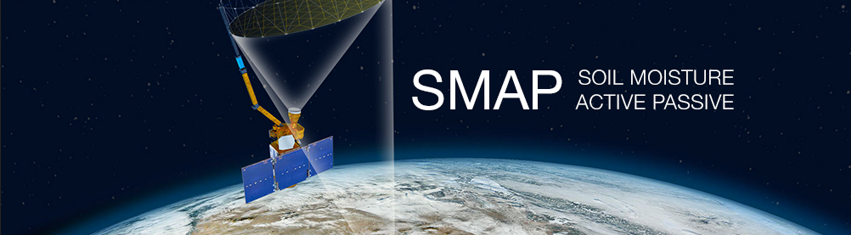


**Downloading and processing 4TB of data (broadband) ~= 18 hours to a day**
 * If we have the storage and compute available, downloading is not a bad option but we are creating copies that later need to be synced or potentially reprocessed.

## Accessing Virtual Data Cubes

Once created and persisted, virtual data cubes are accessible as Zarr regular stores. As of now there is not a canonical way to publish them and advertising them in CMR, although PODAAC/GESDISC have been prototyping using related-links. When we agree on what conventions to use accessing years worth of data will be as simple as 

```python
vds = earthaccess.smart_open(short_name="SPL4SMGP", virtualized=True)
```

In [28]:
%%time

refs = "https://its-live-data.s3-us-west-2.amazonaws.com/test-space/vds/SPL4SMGP.parquet"
daac_fs = ea.get_fsspec_https_session()

fs = fsspec.filesystem("reference",
                       fo=refs,
                       remote_protocol="https",
                       asynchronous=True,
                       remote_options={"asynchronous": True, **daac_fs.storage_options}
                      )

store = zarr.storage.FsspecStore(fs, read_only=True)
ds = xr.open_zarr(store, consolidated=False)
ds

CPU times: user 603 ms, sys: 34.1 ms, total: 637 ms
Wall time: 1.73 s


<xarray.Dataset> Size: 39TB
Dimensions:                            (time: 30704, y: 1624, x: 3856)
Coordinates:
  * time                               (time) datetime64[ns] 246kB 2015-03-31...
  * y                                  (y) float64 13kB 7.31e+06 ... -7.31e+06
  * x                                  (x) float64 31kB -1.736e+07 ... 1.736e+07
Data variables: (12/49)
    baseflow_flux                      (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_column                        (time, y, x) float64 2TB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_row                           (time, y, x) float64 2TB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    depth_to_water_table_from_surface  (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    ...                                 ...
    specific_humidity_lowatmmodlay     (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    surface_pressure                   (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    surface_temp                       (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    temp_lowatmmodlay                  (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    vegetation_greenness_fraction      (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    windspeed_lowatmmodlay             (time, y, x) float32 769GB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
Attributes:
    Source:       v18.1.0
    Institution:  NASA Global Modeling and Assimilation Office
    History:      File written by ldas2daac.x
    Comment:      HDF-5
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv8010/...
    Title:        SMAP L4_SM Geophysical (GPH) Data Granule
    Conventions:  CF
    References:   see SMAP L4_SM Product Specification Documentation
    Contact:      http://gmao.gsfc.nasa.gov

In [22]:
def get_seasonal_ts(ds, varname, lat, lon, month_start, month_end,
                                        window_days=7, split_day_night=True):
    WGS84 = ccrs.PlateCarree()
    EASEGrid2 = ccrs.epsg(6933)
    x, y = EASEGrid2.transform_point(lon, lat, WGS84)
    da = ds[varname].sel(x=x, y=y, method="nearest")
    
    if month_end < month_start:
        mask = (da.time.dt.month >= month_start) | (da.time.dt.month <= month_end)
    else:
        mask = (da.time.dt.month >= month_start) & (da.time.dt.month <= month_end)
    
    da_seasonal = da.sel(time=mask)
    if not split_day_night:
        return da_seasonal.rolling(time=window_days, center=True).mean()
    
    hour = da_seasonal.time.dt.hour
    da_day = da_seasonal.where((hour >= 6) & (hour < 18), drop=True)
    da_night = da_seasonal.where((hour < 6) | (hour >= 18), drop=True)
    
    day_rolling = da_day.rolling(time=window_days, center=True).mean()
    night_rolling = da_night.rolling(time=window_days, center=True).mean()
    
    combined = xr.concat([day_rolling, night_rolling],
                         dim=xr.DataArray(["day", "night"], dims="period", name="period"),
                         join="outer")
    
    return combined


In [23]:
# lat, lon = 40.0, -105.0
lon, lat = -110.78, 29.15

da = get_seasonal_ts(
    ds,
    "sm_surface_wetness",
    lat,
    lon,
    month_start=3,
    month_end=5, 
    window_days=7)
da

<xarray.DataArray 'sm_surface_wetness' (period: 2, time: 7856)> Size: 63kB
dask.array<concatenate, shape=(2, 7856), dtype=float32, chunksize=(1, 8), chunktype=numpy.ndarray>
Coordinates:
  * period   (period) <U5 40B 'day' 'night'
  * time     (time) datetime64[ns] 63kB 2015-03-31T01:30:00 ... 2025-05-31T22...
    x        float64 8B -1.069e+07
    y        float64 8B 3.563e+06
Attributes:
    long_name:         Top layer soil wetness (0-5 cm; wetness units). Soil w...
    valid_max:         1.0
    fmissing_value:    -9999.0
    DIMENSION_LABELS:  ['y', 'x']
    units:             dimensionless
    grid_mapping:      EASE2_global_projection
    valid_min:         0.0

In [9]:
cluster.scale(32)

CPU times: user 1.05 s, sys: 72 ms, total: 1.12 s
Wall time: 1min 26s


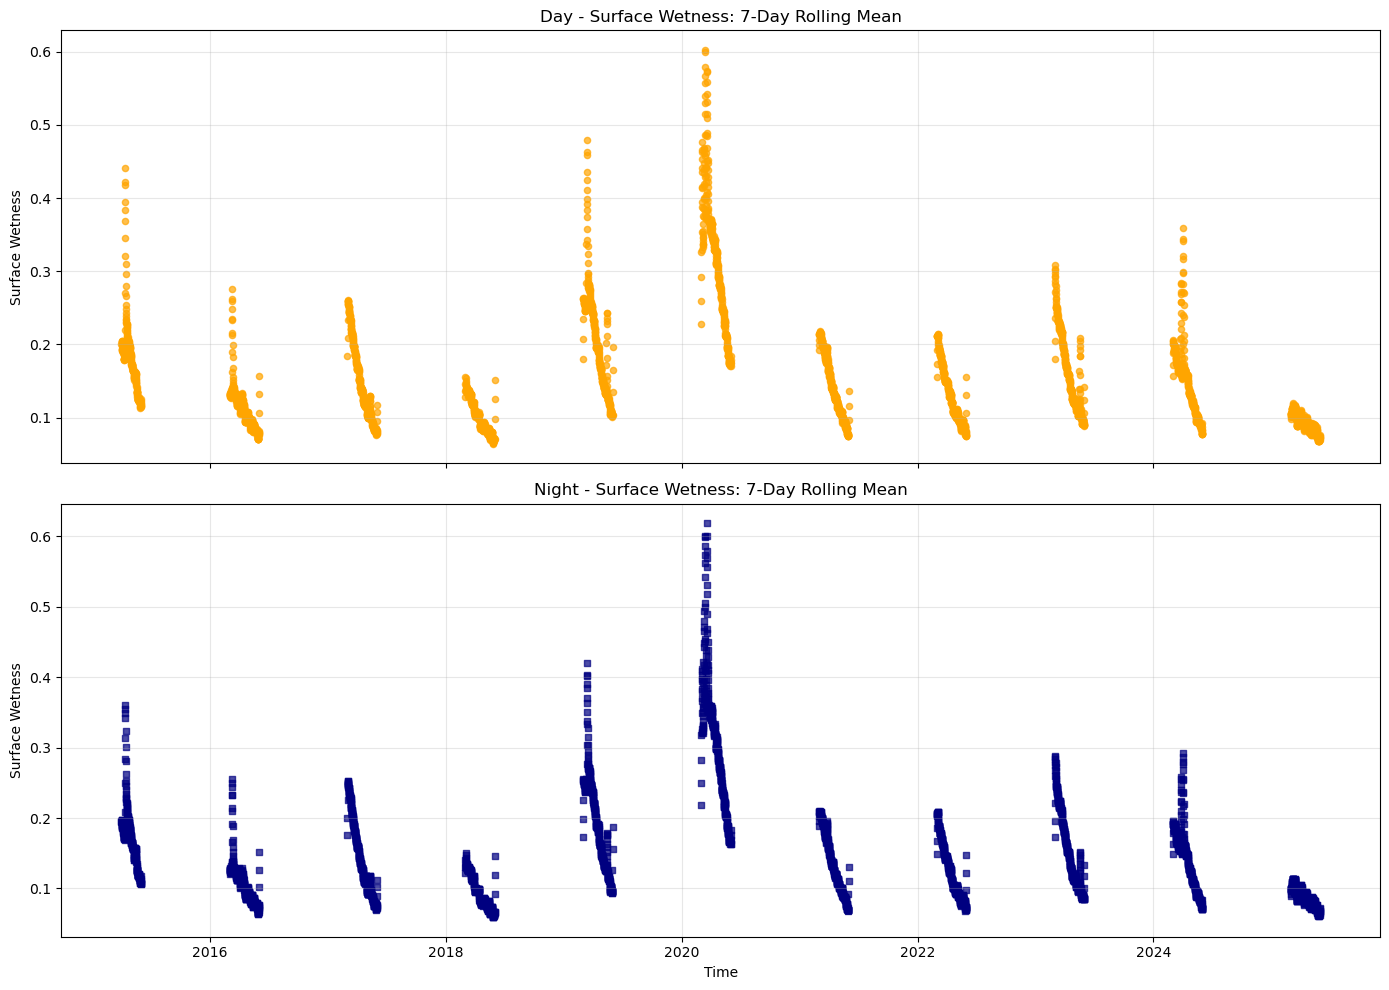

In [26]:
%%time 

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

da_day = da.sel(period="day")
axes[0].scatter(da_day.time, da_day.values, c="orange", marker="o", s=20, alpha=0.7)
axes[0].set_title("Day - Surface Wetness: 7-Day Rolling Mean")
axes[0].set_ylabel("Surface Wetness")
axes[0].grid(True, alpha=0.3)

da_night = da.sel(period="night")
axes[1].scatter(da_night.time, da_night.values, c="navy", marker="s", s=20, alpha=0.7)
axes[1].set_title("Night - Surface Wetness: 7-Day Rolling Mean")
axes[1].set_ylabel("Surface Wetness")
axes[1].set_xlabel("Time")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [31]:
cluster.scale(32)

In [19]:
import calendar

def plot_seasonal_smap_area(ds, varname, lat_min, lat_max, lon_min, lon_max,
                                        month_start, month_end, operation="std"):
    WGS84 = ccrs.PlateCarree()
    EASEGrid2 = ccrs.epsg(6933)
    x_min, y_min = EASEGrid2.transform_point(lon_min, lat_min, WGS84)
    x_max, y_max = EASEGrid2.transform_point(lon_max, lat_max, WGS84)
    
    if y_min > y_max:
        y_min, y_max = y_max, y_min

    ds_bbox = ds[varname].sel(
        x=ds.x[(ds.x >= x_min) & (ds.x <= x_max)],
        y=ds.y[(ds.y >= y_min) & (ds.y <= y_max)]
    )
    # print(f"Selected region: x={len(ds_bbox.x)}, y={len(ds_bbox.y)}")
    if len(ds_bbox.x) == 0 or len(ds_bbox.y) == 0:
        print("ERROR: No data in selected region!")
        return None
    
    # Filter by season
    if month_end < month_start:
        mask = (ds_bbox.time.dt.month >= month_start) | (ds_bbox.time.dt.month <= month_end)
    else:
        mask = (ds_bbox.time.dt.month >= month_start) & (ds_bbox.time.dt.month <= month_end)
    
    ds_seasonal = ds_bbox.sel(time=mask)
    
    if len(ds_seasonal.time) == 0:
        print("No data in selected time period!")
        return None
    ds_seasonal = ds_seasonal.assign_coords(year=("time", ds_seasonal.time.dt.year.values))
    operations = {
        "std": lambda x: x.groupby("year").std(dim="time"),
        "mean": lambda x: x.groupby("year").mean(dim="time"),
        "median": lambda x: x.groupby("year").median(dim="time"),
        "min": lambda x: x.groupby("year").min(dim="time"),
        "max": lambda x: x.groupby("year").max(dim="time"),
        "sum": lambda x: x.groupby("year").sum(dim="time"),
        "var": lambda x: x.groupby("year").var(dim="time")
    }
    
    if operation not in operations:
        print(f"Operation {operation} not supported. Choose from: {list(operations.keys())}")
        return None
    
    yearly_agg = operations[operation](ds_seasonal)
    operation_labels = {
        "std": "Std Dev",
        "mean": "Mean",
        "median": "Median",
        "min": "Min",
        "max": "Max",
        "sum": "Sum",
        "var": "Variance"
    }
    clabel = operation_labels[operation]

    yearly_agg = yearly_agg.rio.write_crs("EPSG:6933")
    yearly_agg_reprojected = yearly_agg.rio.reproject("EPSG:3857")
    osm = gv.tile_sources.OSM().opts(width=800, height=600)
    from holoviews import HoloMap
    
    meshes = {}
    for year in yearly_agg_reprojected.year.values:
        year_data = yearly_agg_reprojected.sel(year=year)
        mesh = gv.QuadMesh(year_data, kdims=["x", "y"], vdims=varname, crs=ccrs.epsg(3857))
        meshes[int(year)] = mesh
    
    holomap = HoloMap(meshes, kdims="year")
    title_text = f"Surface Wetness {clabel} by Year | Months: {calendar.month_name[month_start]}–{calendar.month_name[month_end]}"

    styled_meshes = holomap.opts(
        cmap="YlOrRd_r",
        colorbar=True,
        clabel=clabel,
        alpha=0.7,
        tools=["hover"],
        title=title_text
    )
    
    return osm * styled_meshes

In [30]:
%%time 

plot = plot_seasonal_smap_area(
    ds, "sm_surface_wetness",
    lat_min=33.42, lat_max=34.04,
    lon_min=-117.58, lon_max=-116.25,
    month_start=4, month_end=5,
    operation="mean"
)

pn.pane.HoloViews(plot, widget_location="bottom")

CPU times: user 3.51 s, sys: 138 ms, total: 3.64 s
Wall time: 38.6 s


HoloViews(HoloMap, height=600, sizing_mode='fixed', widget_location='bottom', width=800)